<a href="https://colab.research.google.com/github/kumuds4/BCH/blob/master/Making_the_Most_of_your_Colab_Subscription.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Making the Most of your Colab Subscription



# Access Popular LLMs via Google-Colab-AI Without an API Key

Users with Colab's paid plans have free access to most popular LLMs via google-colab-ai Python library. For more details, refer to the [getting started with google colab ai](https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/Getting_started_with_google_colab_ai.ipynb).

In [ ]:
from google.colab import ai
response = ai.generate_text("What is the capital of France?")
print(response)

## Faster GPUs

Users who have purchased one of Colab's paid plans have access to faster GPUs and more memory. You can upgrade your notebook's GPU settings in `Runtime > Change runtime type` in the menu to select from several accelerator options, subject to availability.

The free of charge version of Colab grants access to Nvidia's T4 GPUs subject to quota restrictions and availability.

You can see what GPU you've been assigned at any time by executing the following cell. If the execution result of running the code cell below is "Not connected to a GPU", you can change the runtime by going to `Runtime > Change runtime type` in the menu to enable a GPU accelerator, and then re-execute the code cell.


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In order to use a GPU with your notebook, select the `Runtime > Change runtime type` menu, and then set the hardware accelerator to the desired option.

## More memory

Users who have purchased one of Colab's paid plans have access to high-memory VMs when they are available. More powerful GPUs are always offered with high-memory VMs.



You can see how much memory you have available at any time by running the following code cell. If the execution result of running the code cell below is "Not using a high-RAM runtime", then you can enable a high-RAM runtime via `Runtime > Change runtime type` in the menu. Then select High-RAM in the Runtime shape toggle button. After, re-execute the code cell.


In [ ]:
import psutil

ram_gb = psutil.virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

## Longer runtimes

All Colab runtimes are reset after some period of time (which is faster if the runtime isn't executing code). Colab Pro and Pro+ users have access to longer runtimes than those who use Colab free of charge.

## Background execution

Colab Pro+ users have access to background execution, where notebooks will continue executing even after you've closed a browser tab. This is always enabled in Pro+ runtimes as long as you have compute units available.



## Relaxing resource limits in Colab Pro

Your resources are not unlimited in Colab. To make the most of Colab, avoid using resources when you don't need them. For example, only use a GPU when required and close Colab tabs when finished.



If you encounter limitations, you can relax those limitations by purchasing more compute units via Pay As You Go. Anyone can purchase compute units via [Pay As You Go](https://colab.research.google.com/signup); no subscription is required.

## Send us feedback!

If you have any feedback for us, please let us know. The best way to send feedback is by using the Help > 'Send feedback...' menu. If you encounter usage limits in Colab Pro consider subscribing to Pro+.

If you encounter errors or other issues with billing (payments) for Colab Pro, Pro+, or Pay As You Go, please email [colab-billing@google.com](mailto:colab-billing@google.com).

## More Resources

### Working with Notebooks in Colab
- [Overview of Colab](/notebooks/basic_features_overview.ipynb)
- [Guide to Markdown](/notebooks/markdown_guide.ipynb)
- [Importing libraries and installing dependencies](/notebooks/snippets/importing_libraries.ipynb)
- [Saving and loading notebooks in GitHub](https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/colab-github-demo.ipynb)
- [Interactive forms](/notebooks/forms.ipynb)
- [Interactive widgets](/notebooks/widgets.ipynb)

<a name="working-with-data"></a>
### Working with Data
- [Loading data: Drive, Sheets, and Google Cloud Storage](/notebooks/io.ipynb)
- [Charts: visualizing data](/notebooks/charts.ipynb)
- [Getting started with BigQuery](/notebooks/bigquery.ipynb)

### Machine Learning Crash Course
These are a few of the notebooks from Google's online Machine Learning course. See the [full course website](https://developers.google.com/machine-learning/crash-course/) for more.
- [Intro to Pandas DataFrame](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/pandas_dataframe_ultraquick_tutorial.ipynb)
- [Linear regression with tf.keras using synthetic data](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/linear_regression_with_synthetic_data.ipynb)


<a name="using-accelerated-hardware"></a>
### Using Accelerated Hardware
- [TensorFlow with GPUs](/notebooks/gpu.ipynb)
- [TPUs in Colab](/notebooks/tpu.ipynb)

<a name="machine-learning-examples"></a>

## Machine Learning Examples

To see end-to-end examples of the interactive machine learning analyses that Colab makes possible, check out these tutorials using models from [TensorFlow Hub](https://tfhub.dev).

A few featured examples:

- [Retraining an Image Classifier](https://tensorflow.org/hub/tutorials/tf2_image_retraining): Build a Keras model on top of a pre-trained image classifier to distinguish flowers.
- [Text Classification](https://tensorflow.org/hub/tutorials/tf2_text_classification): Classify IMDB movie reviews as either *positive* or *negative*.
- [Style Transfer](https://tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization): Use deep learning to transfer style between images.
- [Multilingual Universal Sentence Encoder Q&A](https://tensorflow.org/hub/tutorials/retrieval_with_tf_hub_universal_encoder_qa): Use a machine learning model to answer questions from the SQuAD dataset.
- [Video Interpolation](https://tensorflow.org/hub/tutorials/tweening_conv3d): Predict what happened in a video between the first and the last frame.


Epoch 1/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - achievable_rate_loss: 128.6239 - achievable_rate_mae: 9.1628 - loss: 128.6548 - outage_probability_loss: 0.0308 - outage_probability_mae: 0.1439 - val_achievable_rate_loss: 19.2752 - val_achievable_rate_mae: 2.9990 - val_loss: 19.2948 - val_outage_probability_loss: 0.0196 - val_outage_probability_mae: 0.1124
Epoch 2/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - achievable_rate_loss: 13.1555 - achievable_rate_mae: 2.3520 - loss: 13.1703 - outage_probability_loss: 0.0148 - outage_probability_mae: 0.0975 - val_achievable_rate_loss: 4.4258 - val_achievable_rate_mae: 1.1410 - val_loss: 4.4354 - val_outage_probability_loss: 0.0096 - val_outage_probability_mae: 0.0779
Epoch 3/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - achievable_rate_loss: 3.2978 - achievable_rate_mae: 0.9922 - loss: 3.3070 - outage_probability_loss: 0.0092 - outage_probability_mae: 0.0764 - val_achievable_rate_loss: 1.7774 - val_achievable_rate_mae: 0.6216 - val_loss:

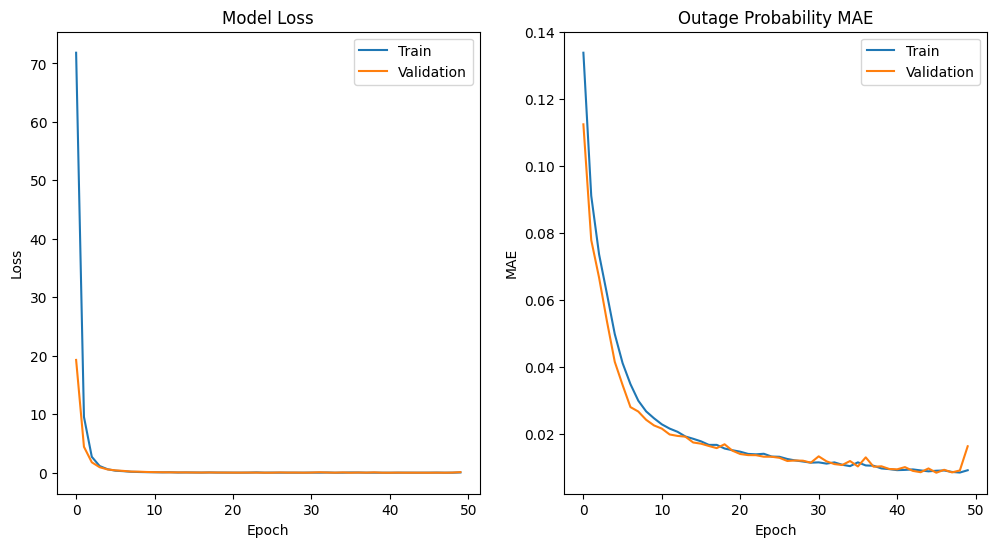

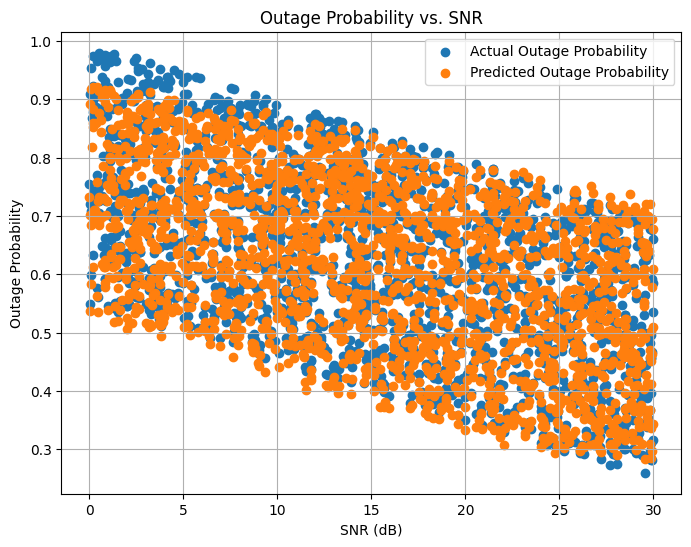

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, GRU
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt




# Imports for TensorFlow and other necessary libraries
import tensorflow as tf
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

# Define the deep learning model architecture
def create_model(input_dim):
    inputs = Input(shape=(1, input_dim)) # Modified: changed input shape to include timestep

    # First hidden layer (Bidirectional LSTM)
    x = Bidirectional(LSTM(64, return_sequences=True))(inputs)

    # Second hidden layer (Bidirectional LSTM)
    x = Bidirectional(LSTM(32))(x)

    # Output layers for outage probability and achievable rate
    outage_probability = Dense(1, activation='sigmoid', name='outage_probability')(x)
    achievable_rate = Dense(1, activation='relu', name='achievable_rate')(x)

    model = Model(inputs=inputs, outputs=[outage_probability, achievable_rate])

    return model

# Generate synthetic data for training and testing
# In a real-world scenario, this data would come from simulations or real-world measurements
def generate_data(num_samples):
    angle = np.random.uniform(0, 2*np.pi, num_samples)
    phase_shift = np.random.uniform(0, 2*np.pi, num_samples)
    snr = np.random.uniform(0, 30, num_samples)  # Example SNR values
    variance = np.random.uniform(0, 1, num_samples)
    spectral_efficiency = np.random.uniform(0, 5, num_samples)
    num_ris_elements = np.random.randint(10, 100, num_samples)

    # Outage probability (simulated) - as an example, this is a simplified calculation
    outage_prob = 0.5 - 0.01 * snr + 0.005 * num_ris_elements
    outage_prob = np.clip(outage_prob, 0, 1)  # Bound between 0 and 1

    # Achievable rate (simulated) - also simplified for demonstration
    achievable_rate = spectral_efficiency * np.log2(1 + snr) + 0.1 * num_ris_elements

    return np.vstack([angle, phase_shift, snr, variance, spectral_efficiency, num_ris_elements]).T, \
           [outage_prob, achievable_rate]

# Generate data
num_samples = 10000
input_dim = 6
X, y = generate_data(num_samples)

# Split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train_outage, y_test_outage, y_train_rate, y_test_rate = train_test_split(
    X, y[0], y[1], test_size=0.2, random_state=42
)

# Reshape input data for LSTM (add a timestep dimension)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))


# Create and compile the model
model = create_model(input_dim)
model.compile(optimizer='adam', loss={'outage_probability': 'mse', 'achievable_rate': 'mse'},
              metrics={'outage_probability': 'mae', 'achievable_rate': 'mae'})

# Train the model
history = model.fit(X_train, {'outage_probability': y_train_outage, 'achievable_rate': y_train_rate},
                    epochs=50, batch_size=32, validation_split=0.1)

# Evaluate the model
loss, outage_loss, rate_loss, outage_mae, rate_mae = model.evaluate(X_test,
                                                                 {'outage_probability': y_test_outage, 'achievable_rate': y_test_rate})
print(f"Test Loss: {loss}, Outage Loss: {outage_loss}, Rate Loss: {rate_loss}")
print(f"Test Outage MAE: {outage_mae}, Test Rate MAE: {rate_mae}")

# Predictions for plotting
predicted_outage, predicted_rate = model.predict(X_test)

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation MAE for outage probability
plt.subplot(1, 2, 2)
plt.plot(history.history['outage_probability_mae'])
plt.plot(history.history['val_outage_probability_mae'])
plt.title('Outage Probability MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot outage probability vs. SNR
plt.figure(figsize=(8, 6))
plt.scatter(X_test[:, 0, 2], y_test_outage, label='Actual Outage Probability') # X_test[:,2] corresponds to SNR
plt.scatter(X_test[:, 0, 2], predicted_outage, label='Predicted Outage Probability')
plt.xlabel('SNR (dB)')
plt.ylabel('Outage Probability')
plt.title('Outage Probability vs. SNR')
plt.legend()
plt.grid(True)
plt.show()

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - achievable_rate_loss: 15.0238 - achievable_rate_mae: 3.1729 - loss: 18.3291 - outage_probability_accuracy: 0.0000e+00 - outage_probability_loss: 3.3075 - val_achievable_rate_loss: 12.5891 - val_achievable_rate_mae: 3.0355 - val_loss: 14.0443 - val_outage_probability_accuracy: 0.0000e+00 - val_outage_probability_loss: 1.4506
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - achievable_rate_loss: 9.8909 - achievable_rate_mae: 2.6460 - loss: 10.9212 - outage_probability_accuracy: 0.0000e+00 - outage_probability_loss: 1.0244 - val_achievable_rate_loss: 11.3390 - val_achievable_rate_mae: 2.9527 - val_loss: 12.2323 - val_outage_probability_accuracy: 0.0000e+00 - val_outage_probability_loss: 0.8495
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - achievable_rate_loss: 9.5969 - achievable_rate_mae: 2.6188 - loss: 10.3356 - outage_probability_accuracy: 0.0000e+00 - outage_probability_loss: 0.7370 - val_achievable_rate_loss: 11.3155 - va

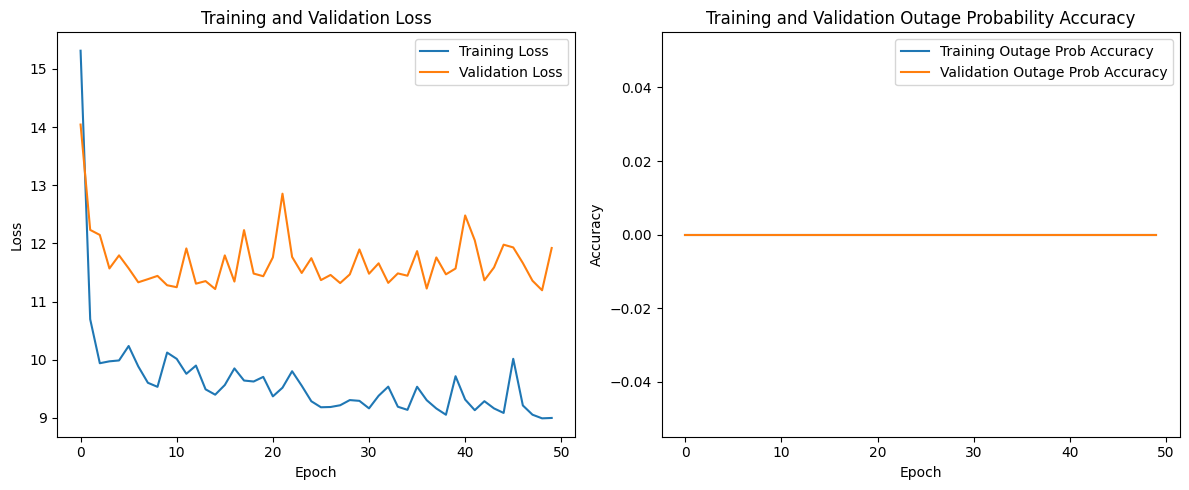

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Bidirectional, LSTM
import matplotlib.pyplot as plt

# 1. Data Generation (Example - replace with actual simulation/analytical data)
def generate_data(num_samples):
    # Simulate various system parameters and calculate corresponding outage_prob, achievable_rate
    # This is a placeholder; replace with your system's specific calculations
    angles = np.random.uniform(0, 2*np.pi, num_samples)
    phase_shifts = np.random.uniform(0, 2*np.pi, num_samples)
    snr_values = np.random.uniform(0, 30, num_samples) # in dB
    std_devs = np.random.uniform(0.1, 1, num_samples)
    spectral_efficiencies = np.random.uniform(1, 5, num_samples)
    threshold_capacities = np.random.uniform(0.5, 2, num_samples)
    num_ris_elements = np.random.randint(10, 100, num_samples)

    # Placeholder for calculating outage_prob and achievable_rate
    # Replace with your actual formulas or simulation results
    outage_prob = np.random.rand(num_samples)
    achievable_rate = np.random.rand(num_samples) * 10

    inputs = np.vstack((angles, phase_shifts, snr_values, std_devs,
                        spectral_efficiencies, threshold_capacities, num_ris_elements)).T
    outputs = np.vstack((outage_prob, achievable_rate)).T
    return inputs, outputs

# Generate sample data
X_data, y_data = generate_data(1000)

# Split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

# 2. Model Definition
input_layer = Input(shape=(X_train.shape[1],)) # Number of input features

# Example with Bidirectional LSTM if treating input as a sequence
# Reshape input for LSTM if necessary (samples, timesteps, features)
# input_reshaped = tf.keras.layers.Reshape((1, X_train.shape[1]))(input_layer)
# hidden_layer_1 = Bidirectional(LSTM(64, return_sequences=True))(input_reshaped)
# hidden_layer_2 = Bidirectional(LSTM(32))(hidden_layer_1)

# Example with Dense layers for simpler cases
hidden_layer_1 = Dense(128, activation='relu')(input_layer)
hidden_layer_2 = Dense(64, activation='relu')(hidden_layer_1)

outage_probability_output = Dense(1, activation='sigmoid', name='outage_probability')(hidden_layer_2)
achievable_rate_output = Dense(1, activation='linear', name='achievable_rate')(hidden_layer_2)

model = Model(inputs=input_layer, outputs=[outage_probability_output, achievable_rate_output])

# Compile the model
model.compile(optimizer='adam',
              loss={'outage_probability': 'binary_crossentropy', 'achievable_rate': 'mse'},
              metrics={'outage_probability': 'accuracy', 'achievable_rate': 'mae'})

# 3. Model Training
history = model.fit(X_train, {'outage_probability': y_train[:, 0], 'achievable_rate': y_train[:, 1]},
                    epochs=50, batch_size=32, validation_split=0.1)

# 4. Model Testing
loss, outage_prob_loss, achievable_rate_loss, outage_prob_acc, achievable_rate_mae = model.evaluate(
    X_test, {'outage_probability': y_test[:, 0], 'achievable_rate': y_test[:, 1]})
print(f"Test Loss: {loss}")
print(f"Test Outage Probability Accuracy: {outage_prob_acc}")
print(f"Test Achievable Rate MAE: {achievable_rate_mae}")

# 5. Plotting
# Plot training and testing loss/metrics
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['outage_probability_accuracy'], label='Training Outage Prob Accuracy')
plt.plot(history.history['val_outage_probability_accuracy'], label='Validation Outage Prob Accuracy')
plt.title('Training and Validation Outage Probability Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Plot Outage Probability vs SNR/SINR (Requires varying SNR/SINR in input and predicting)
# This requires generating data specifically for this plot, varying only SNR/SINR and keeping other params constant
# Example: Varying SNR
snr_range = np.linspace(0, 30, 100) # Example SNR range
# Create input data for prediction with varying SNR and fixed other parameters
# (e.g., avg_angle, avg_phase_shift, avg_std_dev, etc.)
# predict_inputs = np.array([[avg_angle, avg_phase_shift, s, avg_std_dev, avg_spec_eff, avg_thresh_cap, avg_num_ris] for s in snr_range])
# predicted_outage_prob, _ = model.predict(predict_inputs)

# plt.figure()
# plt.plot(snr_range, predicted_outage_prob, label='Predicted Outage Probability')
# plt.title('Outage Probability vs SNR')
# plt.xlabel('SNR (dB)')
# plt.ylabel('Outage Probability')
# plt.grid(True)
# plt.legend()
# plt.show()

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 37.7553 - val_loss: 16.5131
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 16.6577 - val_loss: 16.5121
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 16.6848 - val_loss: 16.5091
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 16.8392 - val_loss: 16.5124
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 17.0348 - val_loss: 16.5558
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 16.7827 - val_loss: 16.4894
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 16.8365 - val_loss: 16.5134
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 16.8338 - val_loss: 16.5197
Epoch 9/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 16.8659 - val_loss: 16.4936
Epoch 10/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 16.6356 - val_loss: 16.5246
Epoch 11/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 16.8629 - val_loss: 16.5099
Epoch 12/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 

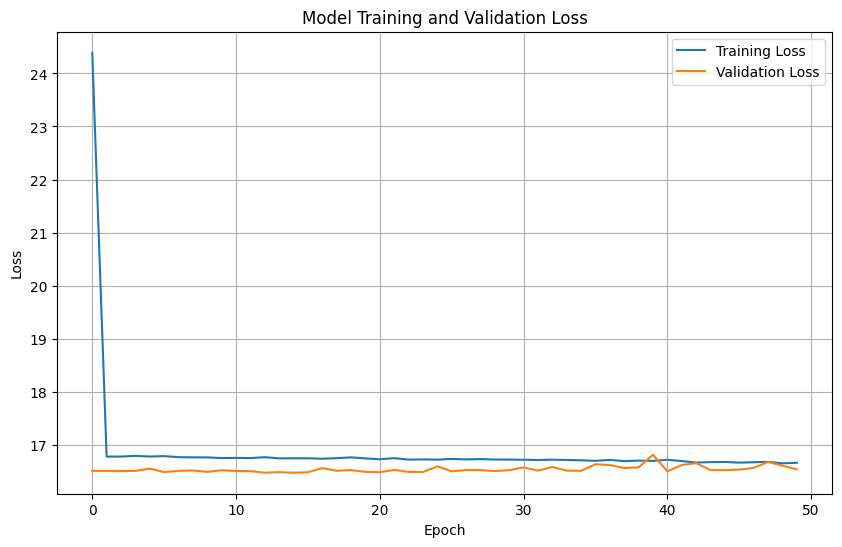

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


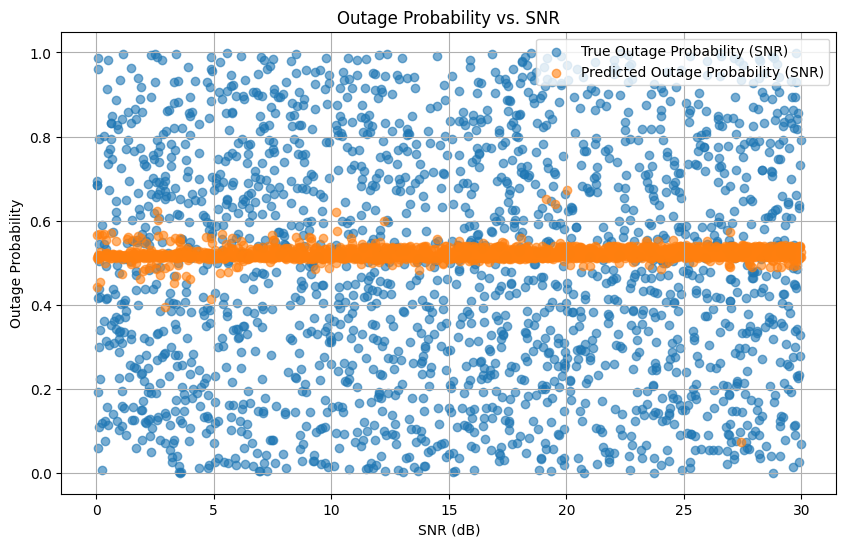

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense
import matplotlib.pyplot as plt

# 1. Data Generation (Example - replace with actual channel models)
def generate_data(num_samples):
    # Simulate various channel conditions and RIS configurations
    angle = np.random.rand(num_samples) * 2 * np.pi
    phase_shift = np.random.rand(num_samples) * 2 * np.pi
    snr = np.random.uniform(0, 30, num_samples) # in dB
    std_dev = np.random.uniform(0.1, 1, num_samples)
    spectral_efficiency = np.random.uniform(1, 10, num_samples)
    threshold_capacity = np.random.uniform(0.5, 5, num_samples)
    num_ris_elements = np.random.randint(16, 256, num_samples)

    # Placeholder for actual outage probability and achievable rate calculation
    # These would typically come from analytical models or simulations
    outage_probability = np.random.rand(num_samples)
    achievable_rate = np.random.uniform(0, 20, num_samples)

    inputs = np.column_stack([angle, phase_shift, snr, std_dev,
                              spectral_efficiency, threshold_capacity, num_ris_elements])
    outputs = np.column_stack([outage_probability, achievable_rate])
    return inputs, outputs

# 2. Model Definition
def create_model(input_shape):
    model = Sequential([
        Bidirectional(LSTM(64, return_sequences=True), input_shape=input_shape),
        Bidirectional(LSTM(32)),
        Dense(2, activation='linear') # Output for outage probability and achievable rate
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# 3. Training and Evaluation
if __name__ == "__main__":
    num_samples = 10000
    inputs, outputs = generate_data(num_samples)

    # Reshape for LSTM input (samples, timesteps, features)
    inputs = np.expand_dims(inputs, axis=1)

    # Split data
    train_size = int(0.8 * num_samples)
    x_train, x_test = inputs[:train_size], inputs[train_size:]
    y_train, y_test = outputs[:train_size], outputs[train_size:]

    model = Sequential([
        Bidirectional(LSTM(64, return_sequences=True), (x_train.shape[1], x_train.shape[2])),
        Bidirectional(LSTM(32)),
        Dense(2, activation='linear') # Output for outage probability and achievable rate
    ])
    model.compile(optimizer='adam', loss='mse')

    history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

    # 4. Plotting Training/Validation Loss
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 5. Predict and Plot Outage Probability vs. SNR/SINR
    # This requires generating a specific test set varying only SNR/SINR
    # For demonstration, we'll use a subset of x_test
    predictions = model.predict(x_test)
    predicted_outage_probability = predictions[:, 0]
    true_outage_probability = y_test[:, 0]

    plt.figure(figsize=(10, 6))
    plt.scatter(x_test[:, 0, 2], true_outage_probability, label='True Outage Probability (SNR)', alpha=0.6)
    plt.scatter(x_test[:, 0, 2], predicted_outage_probability, label='Predicted Outage Probability (SNR)', alpha=0.6)
    plt.xlabel('SNR (dB)')
    plt.ylabel('Outage Probability')
    plt.title('Outage Probability vs. SNR')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Similar plot can be generated for SINR if SINR is an input or derived.

Test Loss: 0.3555
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


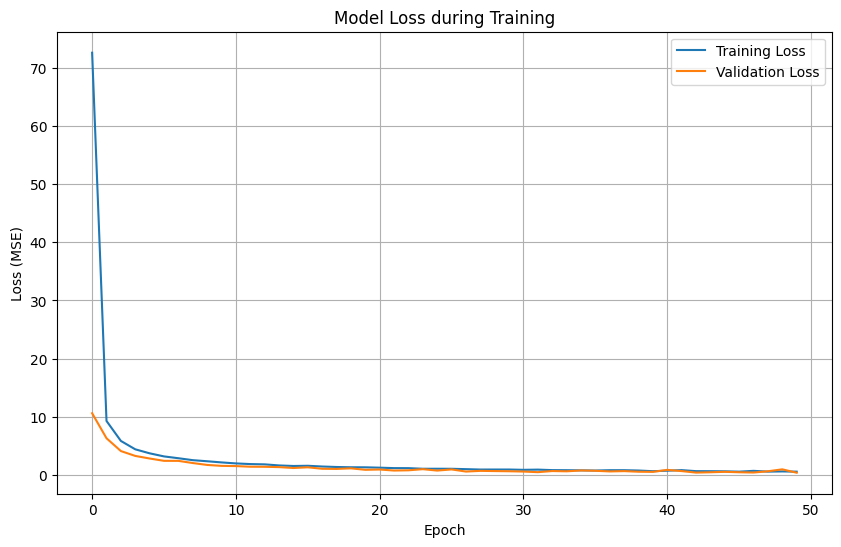

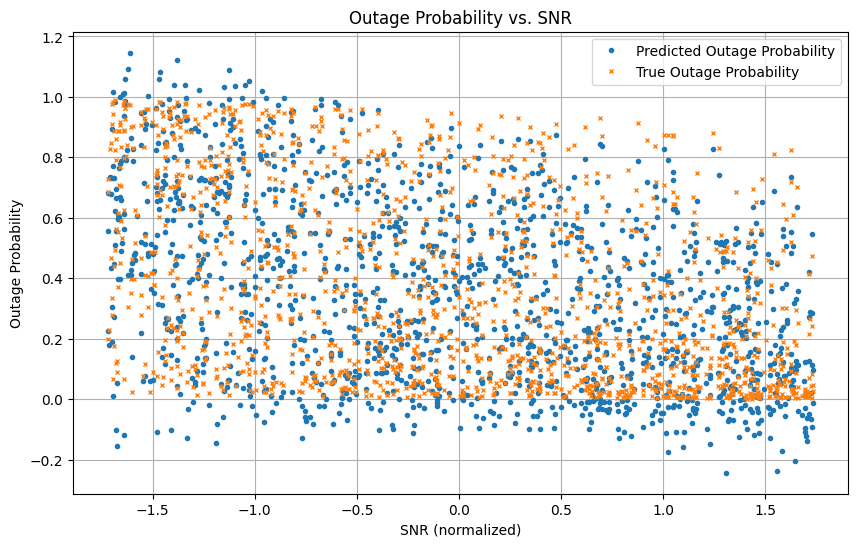

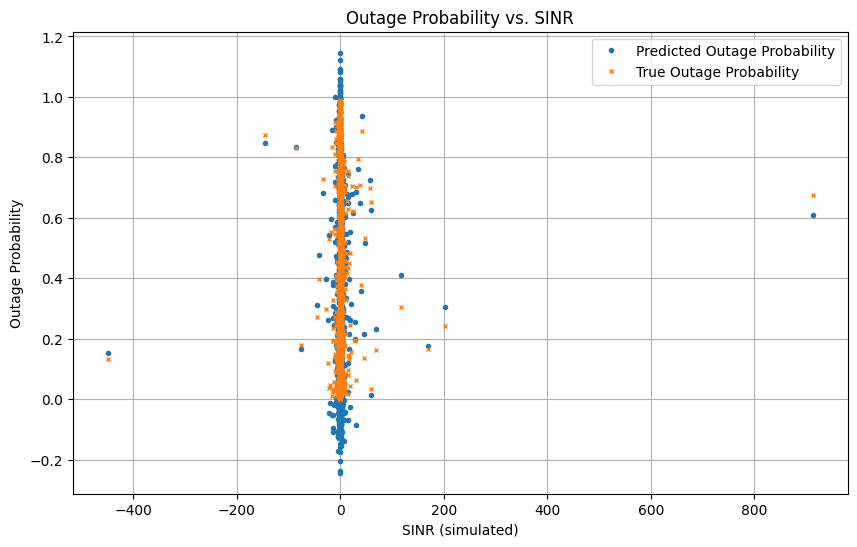

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic data (replace with your actual data)
num_samples = 10000
angles = np.random.rand(num_samples) * 2 * np.pi
phase_shifts = np.random.rand(num_samples) * 2 * np.pi
snr = np.random.rand(num_samples) * 30  # dB
std_dev = np.random.rand(num_samples) * 5
spectral_efficiency = np.random.rand(num_samples) * 10
threshold_capacity = np.random.rand(num_samples) * 5
num_ris_elements = np.random.randint(10, 200, num_samples)

# Simulate outage probability and achievable rate (replace with your actual formulas)
# This is a placeholder for demonstration
outage_probability = 1 / (1 + np.exp(snr / 10 - std_dev + num_ris_elements / 50))
achievable_rate = spectral_efficiency * np.log2(1 + snr / std_dev)

X = np.column_stack((angles, phase_shifts, snr, std_dev, spectral_efficiency, threshold_capacity, num_ris_elements))
y = np.column_stack((outage_probability, achievable_rate))

# Normalize input data (important for neural networks)
X_norm = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

# Split data into training, validation, and testing sets
train_size = int(0.7 * num_samples)
val_size = int(0.15 * num_samples)
test_size = num_samples - train_size - val_size

X_train, y_train = X_norm[:train_size], y[:train_size]
X_val, y_val = X_norm[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X_norm[train_size + val_size:], y[train_size + val_size:]

# Reshape input for LSTM (samples, timesteps, features)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Define the model
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
bidirectional_layer = Bidirectional(LSTM(64, return_sequences=True))(input_layer)
hidden_layer_1 = Dense(32, activation='relu')(bidirectional_layer[:, -1, :]) # Take last output of sequence
hidden_layer_2 = Dense(16, activation='relu')(hidden_layer_1)
output_layer = Dense(2, activation='linear')(hidden_layer_2) # 2 outputs: outage prob and achievable rate

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=0)

# Evaluate the model
loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")

# Make predictions
predictions = model.predict(X_test)
predicted_outage_prob = predictions[:, 0]
predicted_achievable_rate = predictions[:, 1]

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss during Training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()
# Plot Outage Probability vs. SNR (using test data)
plt.figure(figsize=(10, 6))
# Sort by SNR for a smoother plot
sorted_indices_snr = np.argsort(X_test[:, 0, 2]) # Assuming SNR is the 3rd feature (index 2)
plt.plot(X_test[sorted_indices_snr, 0, 2], predicted_outage_prob[sorted_indices_snr], 'o', markersize=3, label='Predicted Outage Probability')
plt.plot(X_test[sorted_indices_snr, 0, 2], y_test[sorted_indices_snr, 0], 'x', markersize=3, label='True Outage Probability')
plt.title('Outage Probability vs. SNR')
plt.xlabel('SNR (normalized)')
plt.ylabel('Outage Probability')
plt.legend()
plt.grid(True)
plt.show()

# Assuming you have SINR values (if not, you'd need to calculate them or include them in your data)
# For demonstration, let's assume SINR is related to SNR and std_dev
# You would replace this with actual SINR calculations or data
simulated_sinr = X_test[:, 0, 2] / X_test[:, 0, 3] # SNR / std_dev as a proxy for SINR
sorted_indices_sinr = np.argsort(simulated_sinr)

plt.figure(figsize=(10, 6))
plt.plot(simulated_sinr[sorted_indices_sinr], predicted_outage_prob[sorted_indices_sinr], 'o', markersize=3, label='Predicted Outage Probability')
plt.plot(simulated_sinr[sorted_indices_sinr], y_test[sorted_indices_sinr, 0], 'x', markersize=3, label='True Outage Probability')
plt.title('Outage Probability vs. SINR')
plt.xlabel('SINR (simulated)')
plt.ylabel('Outage Probability')
plt.legend()
plt.grid(True)
plt.show()